In [9]:
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

In [11]:
from tensorflow.keras import datasets

(X_tn0, y_tn0), (X_te0, y_te0) = datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [12]:
X_tn0.shape

(60000, 28, 28)

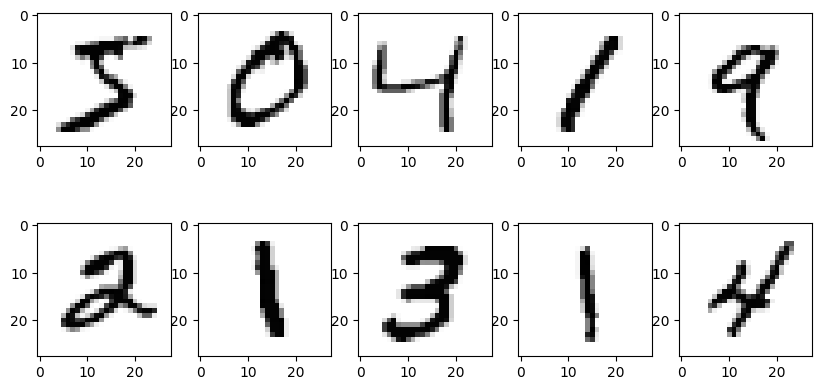

In [13]:
# 데이터 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))

for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_tn0[i].reshape((28, 28)),
               cmap='Greys')

plt.show()

In [15]:
# feature scale 조정
X_tn_re = X_tn0.reshape(60000, 28, 28, 1) # sample 수, 가로, 세로, 채널 수
X_tn = X_tn_re/255.0

print(X_tn.shape)

(60000, 28, 28, 1)


In [17]:
X_te_re = X_te0.reshape(10000, 28, 28, 1)
X_te = X_te_re/255.0
